In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# physio_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Physio/periods/features_segm_1.csv"
# driving_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"
# pvt_path = "/content/drive/MyDrive/Colab Notebooks/FYP/data/Exp4/Exp4/Preprocessed/PVT/data_PVT_no_outliers_mean_sd.csv"

In [3]:
driving_path = "../Exp4/Preprocessed/Driving/features_tor_10s_30s_rows.csv"

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data = pd.read_csv(driving_path)

print(data.shape)

(58, 15)


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58 entries, 0 to 57
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   subject_id             58 non-null     int64  
 1   label_sleep            58 non-null     int64  
 2   label_first_scenario   58 non-null     object 
 3   label_time_exp         58 non-null     int64  
 4   period                 58 non-null     object 
 5   TO_Decision_Rural      58 non-null     int64  
 6   TO_RT_Rural            58 non-null     float64
 7   TO_MaxSWA_Rural        58 non-null     float64
 8   TO_ReengageTime_Rural  40 non-null     float64
 9   TO_MaxBraking_Rural    58 non-null     float64
 10  TO_Decision_Urban      49 non-null     float64
 11  TO_RT_Urban            49 non-null     float64
 12  TO_MaxSWA_Urban        49 non-null     float64
 13  TO_ReengageTime_Urban  39 non-null     float64
 14  TO_MaxBraking_Urban    49 non-null     float64
dtypes: float

In [6]:
data.head()

,subject_id,label_sleep,label_first_scenario,label_time_exp,period,TO_Decision_Rural,TO_RT_Rural,TO_MaxSWA_Rural,TO_ReengageTime_Rural,TO_MaxBraking_Rural,TO_Decision_Urban,TO_RT_Urban,TO_MaxSWA_Urban,TO_ReengageTime_Urban,TO_MaxBraking_Urban
0,1,0,Countryside,16,Country,1,2.450,5.0,12.399,100.0,1.0,1.484,1.0,9.900,100.0
1,2,1,Urban,16,Country,4,2.900,2.0,3.233,0.0,NaN,NaN,NaN,NaN,NaN
2,3,0,Countryside,16,Country,1,2.233,7.0,25.767,100.0,1.0,2.918,5.0,14.068,95.2
3,4,1,Countryside,16,Country,4,1.665,37.0,NaN,100.0,1.0,1.467,10.0,NaN,100.0
4,5,0,Countryside,10,Country,1,1.467,6.0,3.750,100.0,NaN,NaN,NaN,NaN,NaN


In [7]:
label_counts = data["label_sleep"].value_counts()
print(label_counts)

label_sleep
1    31
0    27
Name: count, dtype: int64


C:\Users\kahch\AppData\Local\Temp\ipykernel_46452\3141730654.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


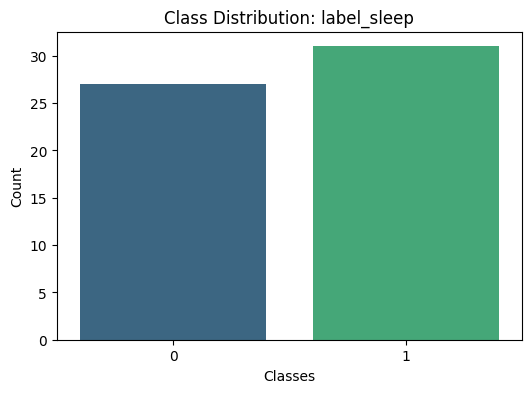

In [8]:
plt.figure(figsize=(6, 4))
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Class Distribution: label_sleep")
plt.xlabel("Classes")
plt.ylabel("Count")
plt.show()


#Data Preprocessing

In [ ]:
columns_to_exclude = data.columns[data.isnull().mean() > 0.5]
data = data.drop(columns=columns_to_exclude)

data.replace([np.inf, -np.inf], np.nan, inplace=True)

numerical_data = data.select_dtypes(include=['number'])

missing_values = numerical_data.isnull().sum()
print("Missing Values:\n", missing_values[missing_values > 0])

data.fillna(numerical_data.mean(), inplace=True)

missing_after = data.isnull().sum()
print("\nMissing Values After Filling:\n", missing_after[missing_after > 0])

if missing_after.sum() == 0:
    print("\nAll missing values have been successfully filled!")
else:
    print("\nThere are still missing values in the dataset.")

Missing Values:
 TO_ReengageTime_Rural    18
TO_Decision_Urban         9
TO_RT_Urban               9
TO_MaxSWA_Urban           9
TO_ReengageTime_Urban    19
TO_MaxBraking_Urban       9
dtype: int64

Missing Values After Filling:
 Series([], dtype: int64)

All missing values have been successfully filled!


In [10]:
data["label_first_scenario"] = data["label_first_scenario"].map({"Countryside": 0, "Urban": 1})
data["period"] = data["period"].map({"Country": 0, "Urban": 1})

print("\n'label_first_scenario' Column After Encoding:\n", data["label_first_scenario"].head())
print("\n'period' Column After Encoding:\n", data["period"].head())


'label_first_scenario' Column After Encoding:
 0    0
1    1
2    0
3    0
4    0
Name: label_first_scenario, dtype: int64

'period' Column After Encoding:
 0    0
1    0
2    0
3    0
4    0
Name: period, dtype: int64


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data["label_sleep"] = label_encoder.fit_transform(data["label_sleep"])

print("Encoded Labels:\n", data["label_sleep"].unique())

Encoded Labels:
 [0 1]


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, precision_score, recall_score, f1_score

X = data.drop(columns=['subject_id', 'label_sleep']).values
y = data['label_sleep'].values

encoder = OneHotEncoder(sparse_output=False)
y_encoded = encoder.fit_transform(y.reshape(-1, 1))

x_train, x_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

print(f"Training Set Size: {x_train.shape}")
print(f"Testing Set Size: {x_test.shape}")

scaler = StandardScaler()
x_train_norm = scaler.fit_transform(x_train)
x_test_norm = scaler.transform(x_test)

Training Set Size: (46, 13)
Testing Set Size: (12, 13)


In [ ]:
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y)
class_weights_dict = dict(enumerate(class_weights))

input_size = x_train_norm.shape[1]
output_size = y_train.shape[1]
embedding_dim = 32

input_layer = layers.Input(shape=(input_size,))

reshaped = layers.Reshape((input_size, 1))(input_layer)

projected = layers.Dense(embedding_dim)(reshaped)

transformer_block = layers.MultiHeadAttention(num_heads=4, key_dim=embedding_dim)(projected, projected)
transformer_block = layers.Dropout(0.1)(transformer_block)
transformer_block = layers.LayerNormalization(epsilon=1e-6)(transformer_block + projected)

flattened = layers.Flatten()(transformer_block)
dense_1 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flattened)
dropout_1 = layers.Dropout(0.5)(dense_1)
output = layers.Dense(output_size, activation='sigmoid')(dropout_1)

model = models.Model(inputs=input_layer, outputs=output)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    x_train_norm, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test_norm, y_test),
    class_weight=class_weights_dict,
    callbacks=[early_stopping],
    verbose=1
)

val_loss, val_accuracy = model.evaluate(x_test_norm, y_test, verbose=0)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

y_pred = model.predict(x_test_norm)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 272ms/step - accuracy: 0.4357 - loss: 2.8940 - val_accuracy: 0.5833 - val_loss: 2.6809
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.6101 - loss: 2.6836 - val_accuracy: 0.5000 - val_loss: 2.6254
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.6639 - loss: 2.6873 - val_accuracy: 0.5000 - val_loss: 2.5755
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.5996 - loss: 2.5526 - val_accuracy: 0.7500 - val_loss: 2.5392
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.6037 - loss: 2.5438 - val_accuracy: 0.6667 - val_loss: 2.5015
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6993 - loss: 2.5112 - val_accuracy: 0.7500 - val_loss: 2.4452
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6617 - loss: 2.3523 - val_accuracy: 0.7500 - val_loss: 2.3976
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6929 - loss: 2.3742 - val_accuracy: 0.6667 - val_loss

In [14]:
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

accuracy = accuracy_score(y_true_classes, y_pred_classes)
if y_test.shape[1] == 2:
    roc_auc = roc_auc_score(y_true_classes, y_pred[:, 1])
else:
    roc_auc = roc_auc_score(y_test, y_pred, multi_class='ovr', average='weighted')

precision = precision_score(y_true_classes, y_pred_classes, average='macro')
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Classification Report:

              precision    recall  f1-score   support

           0       0.80      0.67      0.73         6
           1       0.71      0.83      0.77         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

Accuracy: 0.75
ROC-AUC Score: 0.89
Precision: 0.76
Recall: 0.75
F1-Score: 0.75


<Figure size 1000x800 with 0 Axes>

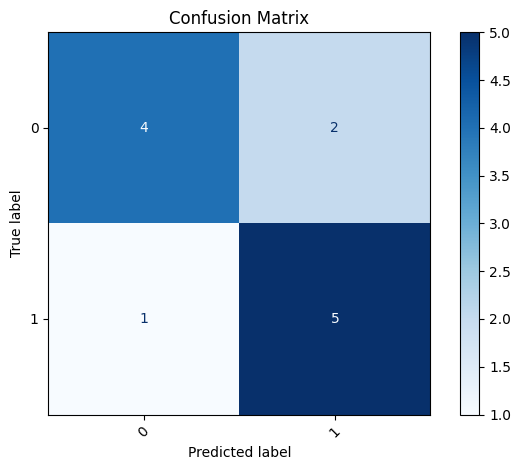

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_classes, y_pred_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

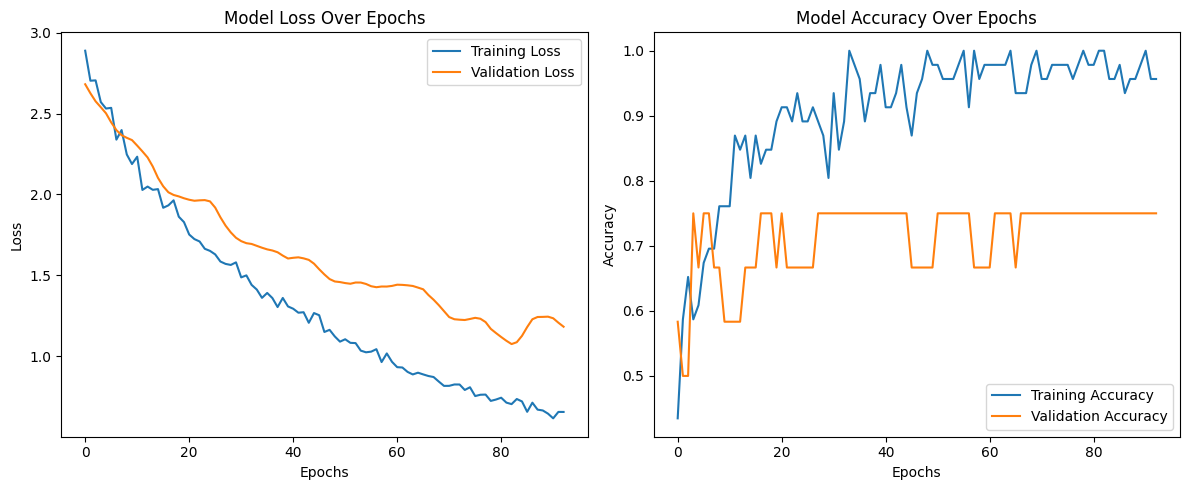

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

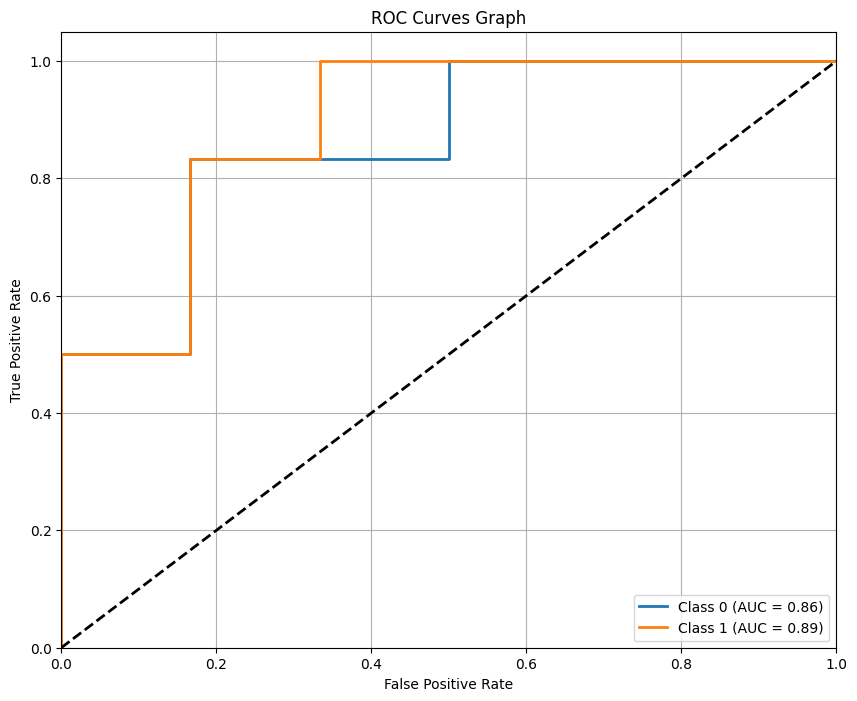

In [17]:
from sklearn.metrics import roc_curve, precision_recall_curve, auc, average_precision_score

plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

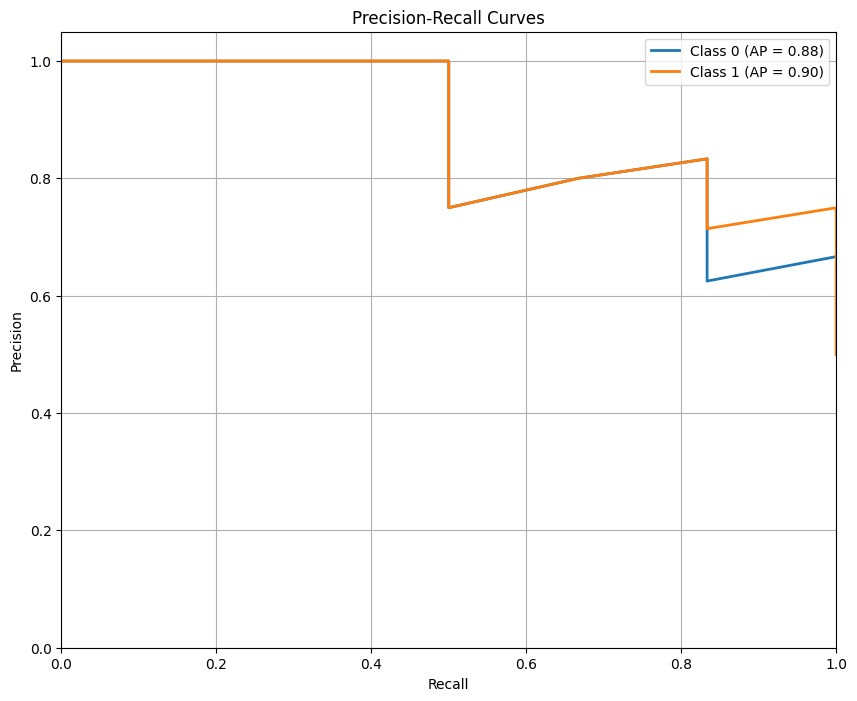

In [18]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [19]:
!pip install keras-tuner

In [ ]:
import keras_tuner as kt

def build_tabtransformer_model(hp):
    input_size = x_train_norm.shape[1]
    output_size = y_train.shape[1]

    embedding_dim = hp.Choice('embedding_dim', values=[16, 32, 64])

    input_layer = layers.Input(shape=(input_size,))

    reshaped = layers.Reshape((input_size, 1))(input_layer)

    projected = layers.Dense(embedding_dim)(reshaped)

    transformer_block = layers.MultiHeadAttention(
        num_heads=hp.Choice('num_heads', values=[2, 4, 8]),
        key_dim=embedding_dim
    )(projected, projected)

    transformer_block = layers.Dropout(
        hp.Choice('dropout_1', values=[0.1, 0.2, 0.3])
    )(transformer_block)

    transformer_block = layers.LayerNormalization(epsilon=1e-6)(transformer_block + projected)

    flattened = layers.Flatten()(transformer_block)

    dense_1 = layers.Dense(
        units=hp.Choice('units_1', values=[64, 128, 256]),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.01)
    )(flattened)

    dense_dropout = layers.Dropout(
        hp.Choice('dropout_2', values=[0.3, 0.4, 0.5])
    )(dense_1)

    output = layers.Dense(output_size, activation='sigmoid')(dense_dropout)

    model = models.Model(inputs=input_layer, outputs=output)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[0.001, 0.005, 0.01])
        ),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

tuner = kt.Hyperband(
    build_tabtransformer_model,
    objective='val_accuracy',
    max_epochs=50,
    factor=3,
    directory='TabTransformer_Tuning',
    project_name='TabTransformer_Hyperparameter_Tuning'
)

hyper_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(f"Embedding Dimension: {best_hps.get('embedding_dim')}")
print(f"Number of Heads: {best_hps.get('num_heads')}")
print(f"Dropout in Transformer Block: {best_hps.get('dropout_1')}")
print(f"Units in Dense Layer: {best_hps.get('units_1')}")
print(f"Dropout in Dense Layer: {best_hps.get('dropout_2')}")
print(f"Learning Rate: {best_hps.get('learning_rate')}")

best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(
    x_train_norm, y_train,
    validation_data=(x_test_norm, y_test),
    epochs=150,
    batch_size=32,
    class_weight=class_weights_dict,
    callbacks=[hyper_early_stopping],
    verbose=1
)

y_pred_best = best_model.predict(x_test_norm)
y_pred_best_classes = np.argmax(y_pred_best, axis=1)
y_true_best_classes = np.argmax(y_test, axis=1)

Trial 90 Complete [00h 00m 08s]
val_accuracy: 0.75

Best val_accuracy So Far: 0.9166666865348816
Total elapsed time: 00h 07m 24s
Best Hyperparameters:
Embedding Dimension: 64
Number of Heads: 8
Dropout in Transformer Block: 0.2
Units in Dense Layer: 256
Dropout in Dense Layer: 0.4
Learning Rate: 0.005
Epoch 1/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 204ms/step - accuracy: 0.5104 - loss: 5.1480 - val_accuracy: 0.7500 - val_loss: 4.4288
Epoch 2/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5892 - loss: 4.8004 - val_accuracy: 0.7500 - val_loss: 4.0623
Epoch 3/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7428 - loss: 4.2839 - val_accuracy: 0.5833 - val_loss: 4.3369
Epoch 4/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.6101 - loss: 4.1830 - val_accuracy: 0.6667 - val_loss: 3.8998
Epoch 5/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7532 - loss: 3.8818 - val_accuracy: 0.6667 - val_loss: 3.8313
Epoch 6/150
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.70

In [21]:
print("Classification Report:")
print(classification_report(y_true_best_classes, y_pred_best_classes))

accuracy = accuracy_score(y_true_best_classes, y_pred_best_classes)
roc_auc = roc_auc_score(y_test, y_pred_best, multi_class='ovr', average='weighted')
precision = precision_score(y_true_best_classes, y_pred_best_classes, average='macro')
recall = recall_score(y_true_best_classes, y_pred_best_classes, average='macro')
f1 = f1_score(y_true_best_classes, y_pred_best_classes, average='macro')

print(f"Accuracy: {accuracy:.2f}")
print(f"ROC-AUC Score: {roc_auc:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.83      0.77         6
           1       0.80      0.67      0.73         6

    accuracy                           0.75        12
   macro avg       0.76      0.75      0.75        12
weighted avg       0.76      0.75      0.75        12

Accuracy: 0.75
ROC-AUC Score: 0.78
Precision: 0.76
Recall: 0.75
F1-Score: 0.75


<Figure size 1000x800 with 0 Axes>

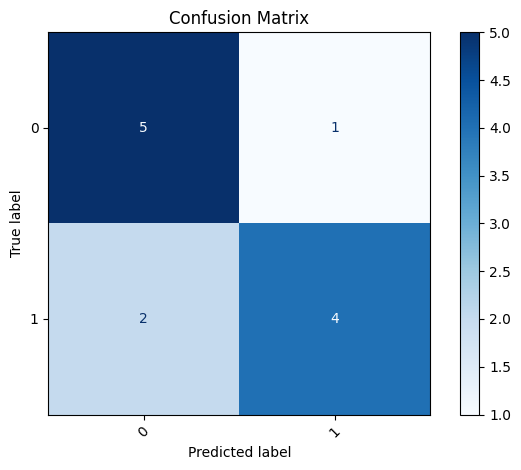

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_true_best_classes, y_pred_best_classes)

plt.figure(figsize=(10, 8))
class_names = label_encoder.classes_
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

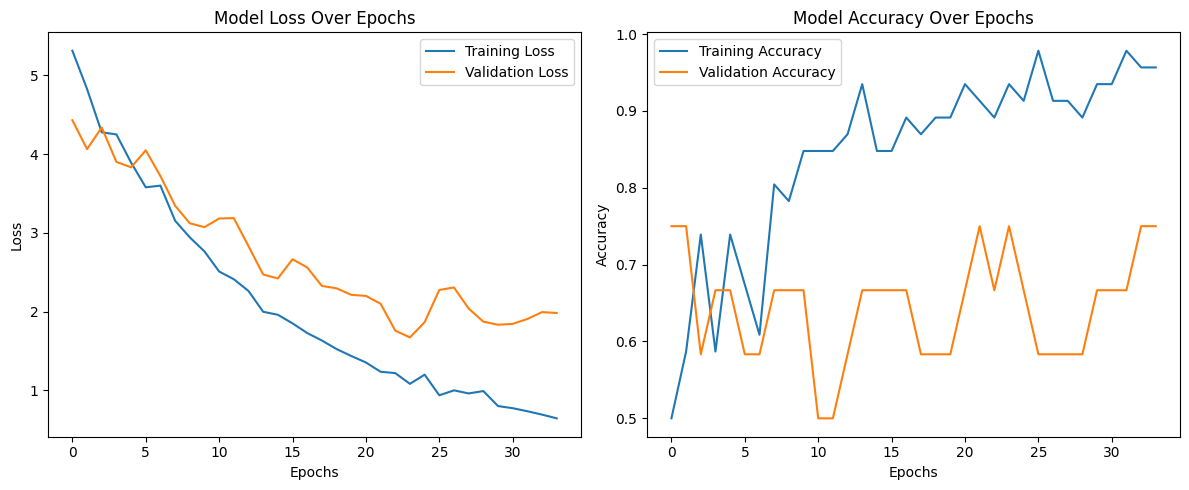

In [23]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

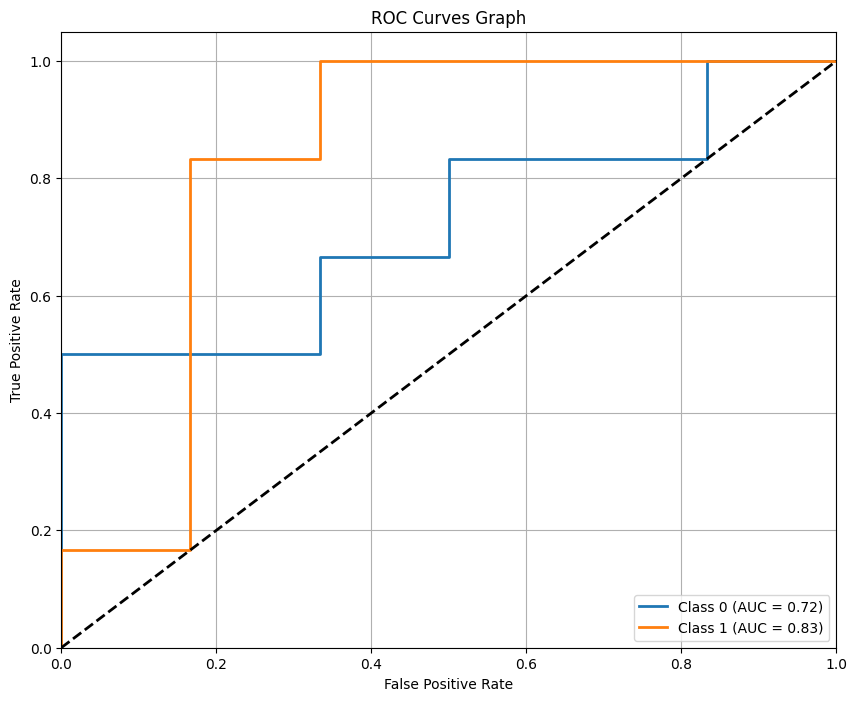

In [24]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test[:, i], y_pred_best[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, 
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Graph')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

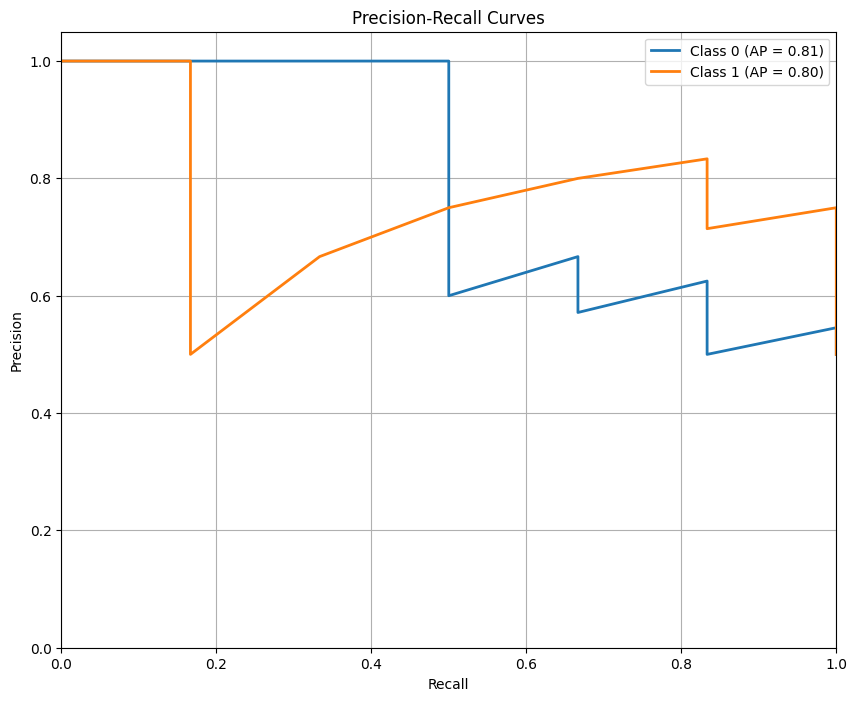

In [25]:
plt.figure(figsize=(10, 8))

n_classes = y_test.shape[1]

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_test[:, i], y_pred_best[:, i])
    avg_precision = average_precision_score(y_test[:, i], y_pred_best[:, i])
    plt.plot(recall, precision, lw=2,
                label=f'Class {label_encoder.inverse_transform([i])[0]} (AP = {avg_precision:.2f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc="best")
plt.grid(True)
plt.show()

In [26]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 13, 1)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 13, 32)    │         64 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 32)    │     16,800 │ dense[0][0],      │
│ (MultiHeadAttentio… │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 13, 32)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 13, 32)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 13, 32)    │         64 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 416)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     53,376 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        258 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 211,688 (826.91 KB)

 Trainable params: 70,562 (275.63 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 141,126 (551.28 KB)

In [27]:
best_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 13)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 13, 1)     │          0 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 13, 64)    │        128 │ reshape_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 13, 64)    │    132,672 │ dense_3[0][0],    │
│ (MultiHeadAttentio… │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 13, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 13, 64)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 13, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 832)       │          0 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    213,248 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 256)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 2)         │        514 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,040,072 (3.97 MB)

 Trainable params: 346,690 (1.32 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 693,382 (2.65 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


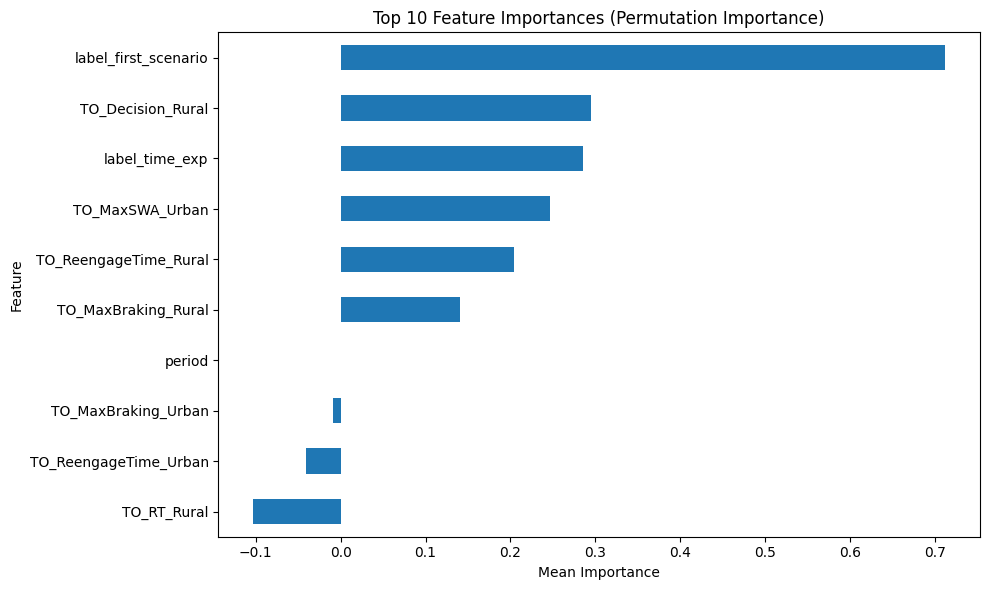

In [ ]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import pandas as pd

scoring = ['r2', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error']

perm_importance = permutation_importance(
    best_model,
    x_test_norm,
    y_test,
    scoring=scoring,
    n_repeats=1,
    random_state=42
)

feature_names = data.drop(columns=['subject_id', 'label_sleep']).columns

feature_importances = pd.DataFrame({
    "Feature": feature_names,
    "Importance": perm_importance['r2']['importances_mean']
}).sort_values(by="Importance", ascending=False)

feature_importances.head(10).plot(
    kind="barh",
    x="Feature",
    y="Importance",
    legend=False,
    figsize=(10, 6)
)
plt.gca().invert_yaxis()
plt.title("Top 10 Feature Importances (Permutation Importance)")
plt.xlabel("Mean Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
